## Environment

In [809]:
import numpy as np
import warnings

In [810]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def round(self, pulled_price, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    reward_price = np.random.binomial(reward_click,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_price, reward_click, reward_cost

## Advertising

In [811]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [812]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [813]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.zeros(self.n_arms)
    self.means_costs = np.zeros(self.n_arms)
    self.sigmas_clicks = np.ones(self.n_arms) * 10
    self.sigmas_costs = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    alpha_clicks = 10  # standard deviation of the noise
    alpha_costs = 10   # standard deviation of the noise
    kernel_clicks = C(3500,"fixed") * RBF(0.6,"fixed") # kernel (squared exponential) with the range of the parameters
    kernel_costs = C(4000,"fixed") * RBF(0.6,"fixed")  # kernel (squared exponential) with the range of the parameters
    #kernel_clicks = C(1.0) * RBF(1.0) # kernel (squared exponential) with the range of the parameters
    #kernel_costs = C(1.0) * RBF(1.0)  # kernel (squared exponential) with the range of the parameters 
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2)  # (normalize_y = True)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2)     # (normalize_y = True)

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    #if self.t < 100 or not(self.t % 10):
    x = np.atleast_2d(self.pulled_arms).T
    y_clicks = self.collected_clicks
    y_costs = self.collected_costs
    # fit the GP
    if len(y_clicks) > 1: 
      self.gp_clicks.fit(x,y_clicks)
      self.gp_costs.fit(x,y_costs)
      # update values of means and sigmas with the new predictions
      self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
      self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
      self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)  # force sigmas > 0
      self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  # force sigmas > 0

    #plt.figure()
    #plt.title("Clicks:" + str(self.t))
    #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
    #plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
    #plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
    #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
    #        np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
    #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
    #plt.xlabel('$x')
    #plt.ylabel('$n(x)$')
    #plt.legend(loc = 'lower right')
    #plt.show()

    #plt.figure()
    #plt.title("Costs:" + str(self.t))
    #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
    #plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
    #plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
    #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
    #        np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
    #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
    #plt.xlabel('$x')
    #plt.ylabel('$c(x)$')
    #plt.legend(loc = 'lower right')
    #plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self, opt_ratexprice):
    # returns index of the maximum value drawn from the arm normal distribution
    sampled_clicks = np.random.normal(self.means_clicks, self.sigmas_clicks)
    sampled_costs = np.random.normal(self.means_costs, self.sigmas_costs)
    return np.argmax(opt_ratexprice*sampled_clicks - sampled_costs)

In [814]:
class GPUCB_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.zeros(self.n_arms)
    self.means_costs = np.zeros(self.n_arms)
    self.sigmas_clicks = np.ones(self.n_arms) * 10
    self.sigmas_costs = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    alpha_clicks = 10  # standard deviation of the noise
    alpha_costs = 10   # standard deviation of the noise
    kernel_clicks = C(3500,"fixed") * RBF(0.6,"fixed") # kernel (squared exponential) with the range of the parameters
    kernel_costs = C(4000,"fixed") * RBF(0.6,"fixed")  # kernel (squared exponential) with the range of the parameters 
    #kernel_clicks = C(1.0) * RBF(1.0) # kernel (squared exponential) with the range of the parameters
    #kernel_costs = C(1.0) * RBF(1.0)  # kernel (squared exponential) with the range of the parameters 
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2)  
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2)     

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    #if self.t < 100 or not(self.t % 10):
    x = np.atleast_2d(self.pulled_arms).T
    y_clicks = self.collected_clicks
    y_costs = self.collected_costs
    # fit the GP
    if len(y_clicks) > 1: 
      self.gp_clicks.fit(x,y_clicks)
      self.gp_costs.fit(x,y_costs)
      # update values of means and sigmas with the new predictions
      self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
      self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
      self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)  # force sigmas > 0
      self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  # force sigmas > 0

    #plt.figure()
    #plt.title("Clicks:" + str(self.t))
    #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
    #plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
    #plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
    #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
    #        np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
    #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
    #plt.xlabel('$x')
    #plt.ylabel('$n(x)$')
    #plt.legend(loc = 'lower right')
    #plt.show()

    #plt.figure()
    #plt.title("Costs:" + str(self.t))
    #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
    #plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
    #plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
    #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
    #        np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
    #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
    #plt.xlabel('$x')
    #plt.ylabel('$c(x)$')
    #plt.legend(loc = 'lower right')
    #plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self, opt_ratexprice):
    # returns index with maximum UCB (UCB_clicks - LCB_costs)
    upper_bound_clicks = self.means_clicks + self.sigmas_clicks
    lower_bound_costs = np.zeros(self.n_arms)  +  (self.means_costs - self.sigmas_costs)*((self.means_costs - self.sigmas_costs)>0)
    upper_bound = opt_ratexprice*upper_bound_clicks - lower_bound_costs
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0]) 
    return pulled_arm

## Simulation

In [815]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [816]:
# generic
T = 365                                # horizon of experiment
n_experiments = 300                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [817]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([0.15,0.1,0.1,0.35,0.1])             # bernoulli distributions for the reward functions
opt_rate = p[np.argmax(p*prices)]                 # optimal arm
print("Pricing (optimal price):")
print("idx: " + str(np.argmax(p*prices)) + "  price: " + str(prices[np.argmax(p*prices)]) + "  rate: " + str(opt_rate) + "  price*rate: " + str(opt_rate*prices[np.argmax(p*prices)]))

Pricing (optimal price):
idx: 3  price: 8  rate: 0.35  price*rate: 2.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768


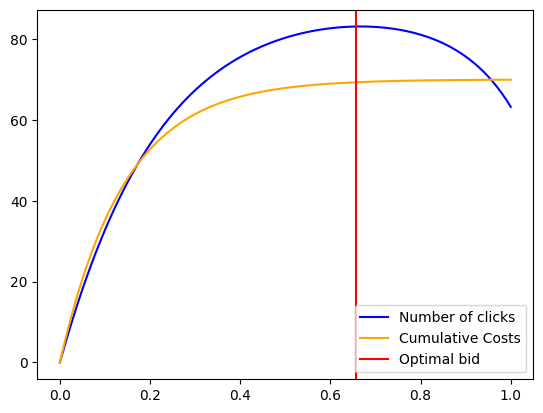

In [818]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 10
sigma_costs = 10
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid = bids[np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.axvline(opt_bid,c='red')
ax.legend(["Number of clicks", "Cumulative Costs", "Optimal bid"])
print("Advertising (optimal bid):")
print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## No optimization

In [819]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [820]:
# experiments
gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []


for e in tqdm(range(0,100)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  gpts_learner = GPTS_Learner(n_arms = n_bids,
                              arms = bids)
  gpucb_learner = GPUCB_Learner(n_arms = n_bids,
                                arms = bids)
  
  gpts_pricing_rewards = np.array([])
  gpucb_pricing_rewards = np.array([])


  for t in range(0,T):  # cycle on time horizon
    
    # GPTS
    pulled_price_ts = np.argmax(p*prices)
    pulled_bid_ts = gpts_learner.pull_arm(opt_rate*prices[pulled_price_ts])
    reward_price_ts, reward_click_ts, reward_cost_ts = env.round(pulled_price_ts, pulled_bid_ts)
    gpts_learner.update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])
    gpts_pricing_rewards = np.append(gpts_pricing_rewards,reward_price_ts*prices[pulled_price_ts]/reward_click_ts) if reward_click_ts > 0 else np.append(gpts_pricing_rewards,0.)

    # GPUCB
    pulled_price_ucb = np.argmax(p*prices)
    pulled_bid_ucb = gpucb_learner.pull_arm(opt_rate*prices[pulled_price_ucb])
    reward_price_ucb, reward_click_ucb, reward_cost_ucb = env.round(pulled_price_ucb, pulled_bid_ucb)
    gpucb_learner.update(pulled_bid_ucb, [reward_click_ucb,reward_cost_ucb])
    gpucb_pricing_rewards = np.append(gpucb_pricing_rewards,reward_price_ucb*prices[pulled_price_ucb]/reward_click_ucb) if reward_click_ucb > 0 else np.append(gpucb_pricing_rewards,0.)

  gpts_rewards_per_experiment.append(gpts_pricing_rewards*gpts_learner.collected_clicks - gpts_learner.collected_costs)
  gpucb_rewards_per_experiment.append(gpucb_pricing_rewards*gpucb_learner.collected_clicks - gpucb_learner.collected_costs)

100%|██████████| 100/100 [27:01<00:00, 16.21s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

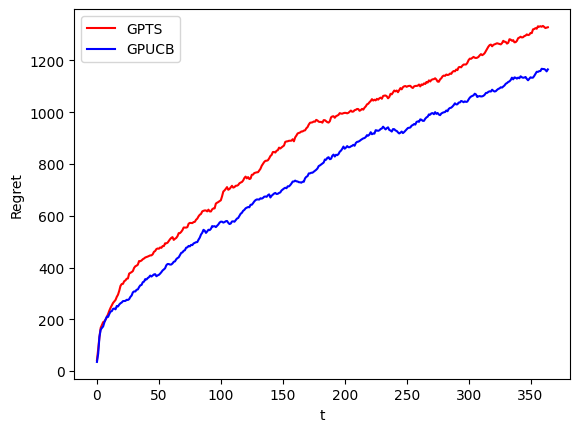

In [821]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["GPTS","GPUCB"])
plt.show

## Optimization

In [825]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.zeros(self.n_arms)
    self.means_costs = np.zeros(self.n_arms)
    self.sigmas_clicks = np.ones(self.n_arms) * 10
    self.sigmas_costs = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    alpha_clicks = 10  # standard deviation of the noise
    alpha_costs = 10   # standard deviation of the noise
    kernel_clicks = C(1.0) * RBF(1.0) # kernel (squared exponential) with the range of the parameters
    kernel_costs = C(1.0) * RBF(1.0)  # kernel (squared exponential) with the range of the parameters 
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2)  # (normalize_y = True)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2)     # (normalize_y = True)

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < 100 or not(self.t % 10):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1: 
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)  # force sigmas > 0
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  # force sigmas > 0

      #plt.figure()
      #plt.title("Clicks:" + str(self.t))
      #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
      #plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
      #plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
      #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
      #        np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
      #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
      #plt.xlabel('$x')
      #plt.ylabel('$n(x)$')
      #plt.legend(loc = 'lower right')
      #plt.show()

      #plt.figure()
      #plt.title("Costs:" + str(self.t))
      #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
      #plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
      #plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
      #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
      #        np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
      #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
      #plt.xlabel('$x')
      #plt.ylabel('$c(x)$')
      #plt.legend(loc = 'lower right')
      #plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self, opt_ratexprice):
    # returns index of the maximum value drawn from the arm normal distribution
    sampled_clicks = np.random.normal(self.means_clicks, self.sigmas_clicks)
    sampled_costs = np.random.normal(self.means_costs, self.sigmas_costs)
    return np.argmax(opt_ratexprice*sampled_clicks - sampled_costs)

In [826]:
class GPUCB_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.zeros(self.n_arms)
    self.means_costs = np.zeros(self.n_arms)
    self.sigmas_clicks = np.ones(self.n_arms) * 10
    self.sigmas_costs = np.ones(self.n_arms) * 10
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    alpha_clicks = 10  # standard deviation of the noise
    alpha_costs = 10   # standard deviation of the noise
    kernel_clicks = C(1.0) * RBF(1.0) # kernel (squared exponential) with the range of the parameters
    kernel_costs = C(1.0) * RBF(1.0)  # kernel (squared exponential) with the range of the parameters 
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2)  
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2)     

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < 100 or not(self.t % 10):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1: 
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)  # force sigmas > 0
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  # force sigmas > 0

      #plt.figure()
      #plt.title("Clicks:" + str(self.t))
      #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
      #plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
      #plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
      #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
      #        np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
      #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
      #plt.xlabel('$x')
      #plt.ylabel('$n(x)$')
      #plt.legend(loc = 'lower right')
      #plt.show()

      #plt.figure()
      #plt.title("Costs:" + str(self.t))
      #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
      #plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
      #plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
      #plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
      #        np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
      #        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
      #plt.xlabel('$x')
      #plt.ylabel('$c(x)$')
      #plt.legend(loc = 'lower right')
      #plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self, opt_ratexprice):
    # returns index with maximum UCB (UCB_clicks - LCB_costs)
    upper_bound_clicks = self.means_clicks + self.sigmas_clicks
    lower_bound_costs = np.zeros(self.n_arms)  +  (self.means_costs - self.sigmas_costs)*((self.means_costs - self.sigmas_costs)>0)
    upper_bound = opt_ratexprice*upper_bound_clicks - lower_bound_costs
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0]) 
    return pulled_arm

In [827]:
# experiments
gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []


for e in tqdm(range(0,100)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  gpts_learner = GPTS_Learner(n_arms = n_bids,
                              arms = bids)
  gpucb_learner = GPUCB_Learner(n_arms = n_bids,
                                arms = bids)
  
  gpts_pricing_rewards = np.array([])
  gpucb_pricing_rewards = np.array([])


  for t in range(0,T):  # cycle on time horizon
    
    # GPTS
    pulled_price_ts = np.argmax(p*prices)
    pulled_bid_ts = gpts_learner.pull_arm(opt_rate*prices[pulled_price_ts])
    reward_price_ts, reward_click_ts, reward_cost_ts = env.round(pulled_price_ts, pulled_bid_ts)
    gpts_learner.update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])
    gpts_pricing_rewards = np.append(gpts_pricing_rewards,reward_price_ts*prices[pulled_price_ts]/reward_click_ts) if reward_click_ts > 0 else np.append(gpts_pricing_rewards,0.)

    # GPUCB
    pulled_price_ucb = np.argmax(p*prices)
    pulled_bid_ucb = gpucb_learner.pull_arm(opt_rate*prices[pulled_price_ucb])
    reward_price_ucb, reward_click_ucb, reward_cost_ucb = env.round(pulled_price_ucb, pulled_bid_ucb)
    gpucb_learner.update(pulled_bid_ucb, [reward_click_ucb,reward_cost_ucb])
    gpucb_pricing_rewards = np.append(gpucb_pricing_rewards,reward_price_ucb*prices[pulled_price_ucb]/reward_click_ucb) if reward_click_ucb > 0 else np.append(gpucb_pricing_rewards,0.)

  gpts_rewards_per_experiment.append(gpts_pricing_rewards*gpts_learner.collected_clicks - gpts_learner.collected_costs)
  gpucb_rewards_per_experiment.append(gpucb_pricing_rewards*gpucb_learner.collected_clicks - gpucb_learner.collected_costs)

100%|██████████| 100/100 [56:25<00:00, 33.85s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

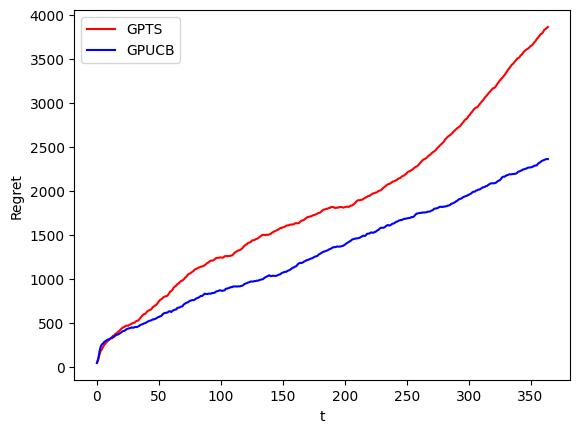

In [828]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["GPTS","GPUCB"])
plt.show